# Error Estimation

In [1]:
import h5py
import numpy as np
from itertools import product

import matplotlib.pyplot as plt

import sys
sys.path.append("/users/pkeller/code/ClosurePhaseAnalysis/")
from library import dspec

## Load Data

In [2]:
# data paths
path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ28_FE_B2_AVG.h5"
xps_path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ28_FE_B2_XPS.h5"
modelpath = "/users/pkeller/code/H1C_IDR3.2/data/scaling_EQ28_FEB2.dat"


# load covariance data
with h5py.File(path, "r") as f:
    frq = f["FRQ"][()]
    lst = f["LST"][()]
    eicp_xx = f["eicp XX (2)"][()]
    eicp_yy = f["eicp YY (2)"][()]
    cov_xx = f["cov XX"][()]
    cov_yy = f["cov YY"][()]
    
# load cross-power spectral data
with h5py.File(xps_path, "r") as f:
    print(f.keys())
    xps_xx = f["XPS XX"][()]
    xps_yy = f["XPS YY"][()]
    w_xx = f["weights cross XX"][()]
    w_yy = f["weights cross YY"][()]

# flag galactic plane
glx_flags = (lst > 6.25) & (lst < 10.75)
    
# load scaling coefficients
A = np.loadtxt(modelpath)
A = A[~glx_flags]
    
Nlst = len(lst)
Ntrx = xps_xx.shape[0]
Ntry = xps_yy.shape[0]
Ndx = xps_xx.shape[-1]
Ndy = xps_yy.shape[-1]

<KeysViewHDF5 ['ERR AVG', 'ERR XX', 'ERR XX AVG', 'ERR YY', 'ERR YY AVG', 'LST', 'Noise AVG', 'Noise XX AVG', 'Noise YY AVG', 'VAR XX', 'VAR YY', 'XPS AVG', 'XPS XX', 'XPS XX AVG', 'XPS YY', 'XPS YY AVG', 'delay', 'scaling', 'weights cross XX', 'weights cross YY', 'weights var XX', 'weights var YY']>


## Compute Weights

In [3]:
w_xx = np.array([[1 / (cov_xx[:, i, i] * cov_xx[:, j, j] * A**2) for i in range(Ntrx)] for j in range(Ntrx)])
w_yy = np.array([[1 / (cov_yy[:, i, i] * cov_yy[:, j, j] * A**2) for i in range(Ntry)] for j in range(Ntry)])

## Compute Noise-only Power Spectrum Variance

In [4]:
def noise_var(w, cov):
    w = w / w.sum()
    trange = 4 * (range(w.shape[0]),)
    return np.sum([np.sum(w[i, j] * w[k, l] * cov[:, i, k] * cov[:, j, l] * A[:, 0]**2) for i, j, k, l in product(*trange)])
        
var_xx = noise_var(w_xx, cov_xx)
var_yy = noise_var(w_yy, cov_yy)

In [21]:
# neglecting covariances
def noise_var(w, cov):
    w = w / w.sum()
    trange = 2 * (range(w.shape[0]),)
    return np.sum([np.sum(w[i, j] * w[i, j] * cov[:, i, i] * cov[:, j, j] * A**2) for i, j in product(*trange)])
        
var_xx_diag = noise_var(w_xx, cov_xx)
var_yy_diag = noise_var(w_yy, cov_yy)

In [22]:
# normalise noise variance
fs = 10.24 * 1e-6
var_xx_norm = var_xx_diag / fs**4 * Ndx**2 * 2
var_yy_norm = var_yy_diag / fs**4 * Ndy**2 * 2

In [23]:
print(np.log10(np.sqrt(var_xx_norm.real)))

5.5242815543197


## Average Cross-Power Spectra

In [95]:
def avg_xps(xps, w):
    return (np.moveaxis(xps, -1, 0) * w).sum(axis=(1, 2, 3)) / w.sum(axis=(0, 1, 2))

xps_xx_avg = avg_xps(xps_xx, w_xx)
xps_yy_avg = avg_xps(xps_yy, w_yy)

## Plot

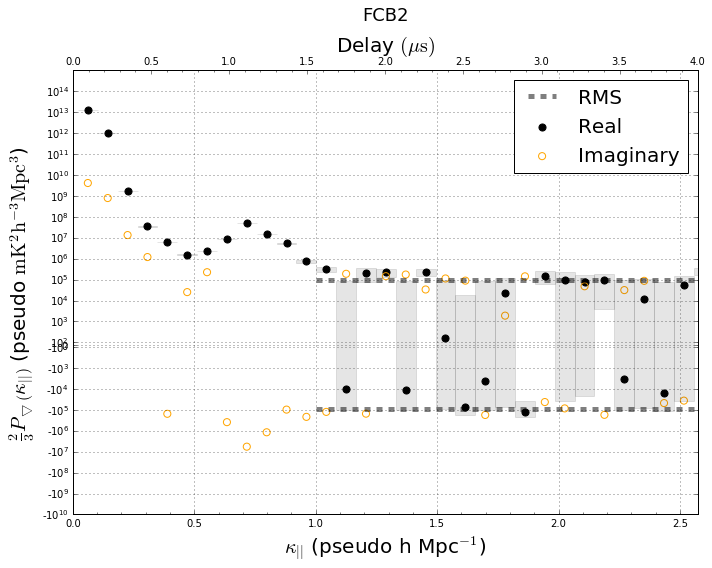

In [90]:
err_xx = np.ones_like(xps_xx_avg) * np.sqrt(var_xx_norm)
delay = dspec.delay(n=Ndx)

dspec.power_plot(
    delay[::2],
    xps_xx_avg[..., ::2], 
    err_xx[..., ::2],
    linthresh=1e3,
    legend=True,
    onesided=True,
    title="FCB2",
)